In [5]:
# 📦 0.  Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Time–series / stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import acf, pacf
import ruptures as rpt

# ML / clustering / anomaly
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

# Deep‑learning modelling (optional)
import tensorflow as tf
from tensorflow import keras

In [6]:
DATA_PATH   = Path("/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv")   # full file
DATE_COL    = "INFODT"        # mm/yyyy string
PATIENT_COL = "PATNO"
SCORE_COL   = "NP3TOT"

# ---- Load ----
df = (
    pd.read_csv(DATA_PATH, parse_dates=[DATE_COL], dayfirst=False, infer_datetime_format=True)
      .sort_values([PATIENT_COL, DATE_COL])
)

# ---- Minimal QC ----
# 1. Remove rows lacking core fields
df = df.dropna(subset=[PATIENT_COL, DATE_COL, SCORE_COL])

# 2. Cast numeric cols (coerce errors → NaN, then leave NaNs for modelling masks)
num_cols = df.columns[df.dtypes == "object"].difference([DATE_COL, PATIENT_COL, "EVENT_ID"])
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# 3. Compute visit index and Δt (days) per patient
df["visit_idx"] = df.groupby(PATIENT_COL).cumcount()
df["days_since_prev"] = (
    df.groupby(PATIENT_COL)[DATE_COL].diff().dt.days
)

# Quick glimpse
print(df[[PATIENT_COL, DATE_COL, "visit_idx", "days_since_prev", SCORE_COL]].head())

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_6692/3001162095.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.read_csv(DATA_PATH, parse_dates=[DATE_COL], dayfirst=False, infer_datetime_format=True)
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_6692/3001162095.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(DATA_PATH, parse_dates=[DATE_COL], dayfirst=False, infer_datetime_format=True)


   PATNO     INFODT  visit_idx  days_since_prev  NP3TOT
0   3000 2011-02-01          0              NaN     4.0
1   3000 2012-03-01          1            394.0     1.0
2   3000 2013-02-01          2            337.0     4.0
3   3000 2014-03-01          3            393.0     2.0
4   3000 2015-03-01          4            365.0    19.0


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_6692/663812524.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq="M"))[SCORE_COL]


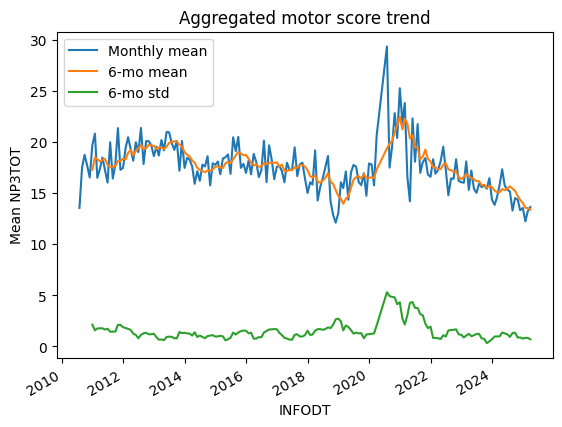

In [7]:
# Aggregate across patients (mean per calendar month)
monthly = (
    df.set_index(DATE_COL)
      .groupby(pd.Grouper(freq="M"))[SCORE_COL]
      .mean()
      .dropna()
)

# Rolling 6‑month mean & std
roll_mean = monthly.rolling(6).mean()
roll_std  = monthly.rolling(6).std()

fig, ax = plt.subplots()
monthly.plot(label="Monthly mean", ax=ax)
roll_mean.plot(label="6‑mo mean", ax=ax)
roll_std.plot(label="6‑mo std", ax=ax)
ax.legend(); ax.set_ylabel("Mean NP3TOT");
plt.title("Aggregated motor score trend");
plt.show()

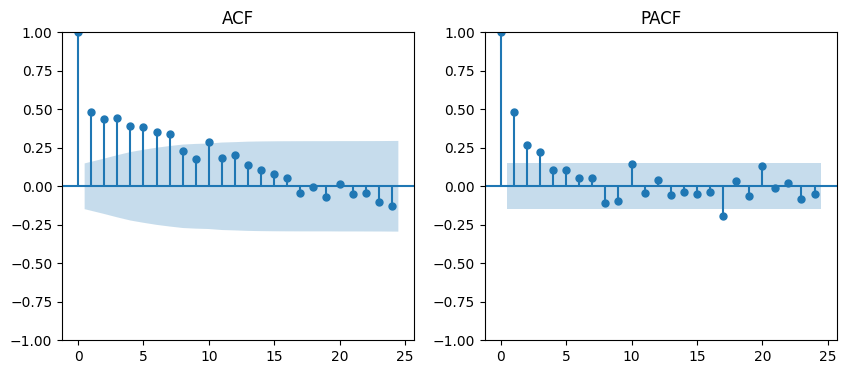

In [8]:
# ACF & PACF
fig, axes = plt.subplots(1,2, figsize=(10,4))
sm.graphics.tsa.plot_acf(monthly, lags=24, ax=axes[0]); axes[0].set_title("ACF")
sm.graphics.tsa.plot_pacf(monthly, lags=24, ax=axes[1]); axes[1].set_title("PACF");

In [9]:
# Example: choose patients with ≥6 visits
candidates = df.groupby(PATIENT_COL)["visit_idx"].max().loc[lambda s: s>=5].index[:100]

change_points = []

for p in candidates:
    ts = df.loc[df[PATIENT_COL]==p, SCORE_COL].values
    algo = rpt.Pelt(model="rbf", min_size=2, jump=1)
    bkps = algo.fit(ts).predict(pen=5)   # Tune 'pen' parameter
    if len(bkps) > 1:                    # >1 bp incl. end
        change_points.append((p, bkps[:-1]))   # drop last index (len(ts))

In [10]:
# ARIMA on the aggregated series
arima = tsa.ARIMA(monthly, order=(1,1,1)).fit()
print(arima.summary())

pred = arima.get_forecast(steps=12)
pred_ci = pred.conf_int()

                               SARIMAX Results                                
Dep. Variable:                 NP3TOT   No. Observations:                  174
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -359.638
Date:                Sun, 04 May 2025   AIC                            725.276
Time:                        17:19:06   BIC                            734.736
Sample:                             0   HQIC                           729.114
                                - 174                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0204      0.083     -0.246      0.805      -0.183       0.142
ma.L1         -0.7205      0.064    -11.186      0.000      -0.847      -0.594
sigma2         3.7262      0.227     16.436      0.0

/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an int

In [11]:
# Build equal‑length windowed sequences (pad with NaN → fill with forward fill)
max_len = df["visit_idx"].max()+1
def build_seq(x):
    seq = x.set_index("visit_idx")[SCORE_COL].reindex(range(max_len))
    return seq.fillna(method="ffill").fillna(method="bfill").values

seqs = np.vstack(df.groupby(PATIENT_COL).apply(build_seq).values)   # shape n_patients × max_len

# DTW distance matrix (pairwise) – optional heavy, sample subset
from scipy.spatial.distance import squareform, pdist

def dtw_dist(u, v):
    return dtw(u, v)

dist_matrix = squareform(pdist(seqs, metric=dtw_dist))

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_6692/4257868488.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return seq.fillna(method="ffill").fillna(method="bfill").values
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_6692/4257868488.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seqs = np.vstack(df.groupby(PATIENT_COL).apply(build_seq).values)   # shape n_patients × max_len


In [12]:
# Hierarchical clustering (Ward)
clust = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average')
labels = clust.fit_predict(dist_matrix)

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'